In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

In [2]:
#set initial value
time_devided = 65 #6.5s
pressure_former = 20580
pressure_latter = 20620
time_range = 100 #10s

In [3]:
def normalize(df_result: pd.DataFrame) -> pd.DataFrame:
    if df_result.shape[1] != 9:
        raise ValueError(f"Input has {df_result.shape[1]} columns; should be 9")
    df=df_result.set_axis(
        [
            "time",
            "acc_x",
            "acc_y",
            "acc_z",
            "pitch",
            "roll",
            "yaw",
            "pressure",
            "flag",
        ],
        axis='columns'
    )
    return df


In [53]:

def score(df_result: pd.DataFrame, target_pressure: float) -> float:
    err_square = (df_result - target_pressure)**2
    loss_square = err_square["pressure"].head(time_range).sum()

    #lossの最小
    min_loss_square = loss_square

    for i in range(100000):
        loss_square = loss_square + err_square.at[i + time_range, "pressure"] - err_square.at[i, "pressure"]
        min_loss_square = min(min_loss_square, loss_square)
        if (i+time_range+1) >= len(df_result.index):
            break
    

    score = np.sqrt(min_loss_square / time_range)
    return score

In [54]:
def print_result(df_result:pd.DataFrame, df_target: pd.DataFrame, dir_out='./output/', filename=datetime.datetime.now().strftime("%Y-%m-%d %H%M%S")):
   #normalize
   df = normalize(df_result)
   #trunc
   df_trunc = df[df["flag"] >= 1].head(len(df_target.index)).reset_index(drop=True)

   #devide data into former and latter one
   df_former = df[df["time"] < time_devided].reset_index(drop=True)
   df_latter = df[df["time"] > time_devided].reset_index(drop=True)

   score_val= score(df_former,pressure_former) +score(df_latter,pressure_latter)
   fig,axes=plt.subplots(3,1,figsize=(8,12))
   
   fig.suptitle(f'Score = {score_val:.2f}')
   fig.set_tight_layout('tight')
   # Accel
   axes[0].set_xlabel('Time[s]')
   axes[0].set_ylabel('Acceleration[$m/s^2$]')
   axes[0].plot(df_trunc['acc_x'],c='red',label='acc_x')
   axes[0].plot(df_trunc['acc_y'],c='green',label='acc_y')
   axes[0].plot(df_trunc['acc_z'],c='blue',label='acc_z')
   axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )

   # Orientation
   axes[1].set_xlabel('Time[s]')
   axes[1].set_ylabel('Angle[deg]')
   axes[1].plot(df_trunc['pitch'],c='red',label='pitch')
   axes[1].plot(df_trunc['roll'],c='green',label='roll')
   axes[1].plot(df_trunc['yaw'],c='blue',label='yaw')
   axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )

   # Orientation
   axes[2].set_xlabel('Time[s]')
   axes[2].set_ylabel('Pressure[mbar]')
   axes[2].plot(df_trunc['pressure'],c='black',label='Result')
   axes[2].plot(df_target['pressure'],c='black',ls='--',label='Target')
   axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )
   
   # Output
   path_out = Path(dir_out)
   if not path_out.exists():
      path_out.mkdir(parents=True, exist_ok=True)
   plt.savefig(path_out.joinpath(f"{filename}.png"), bbox_inches="tight")
   plt.savefig(path_out.joinpath(f"{filename}.pdf"), bbox_inches="tight")

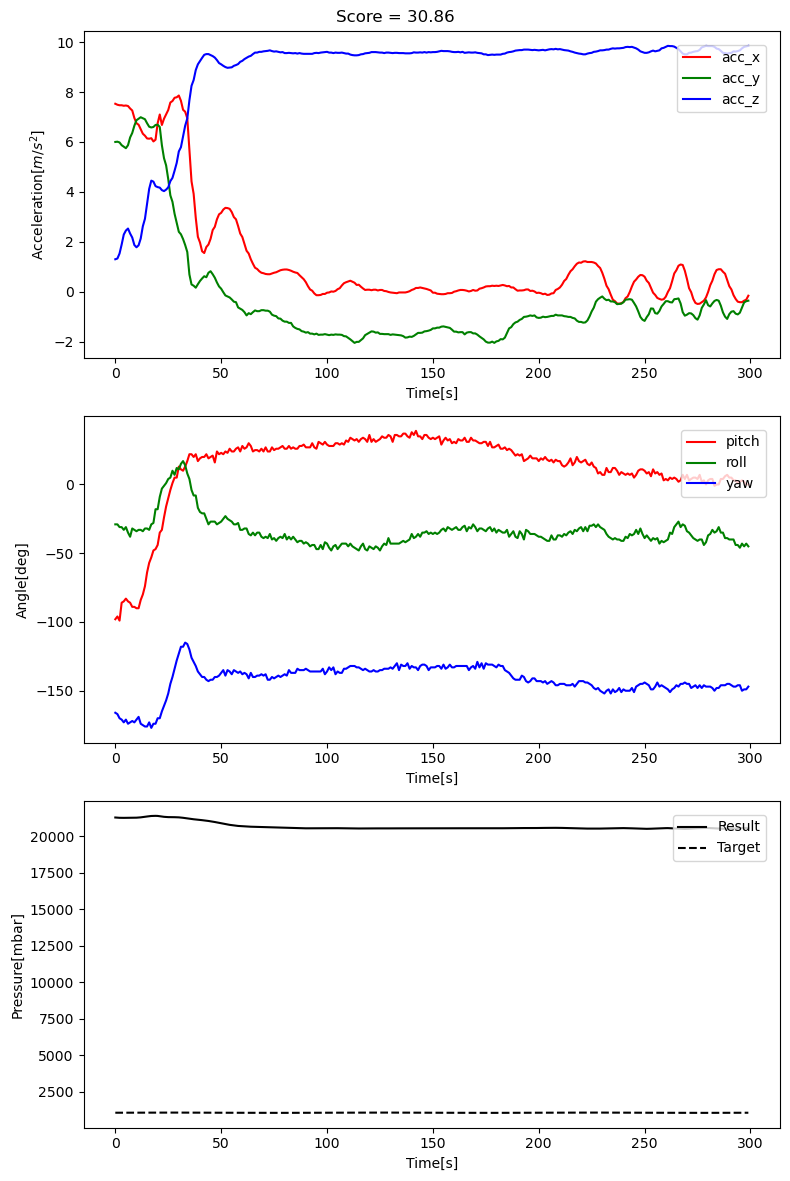

In [55]:
print_result(pd.read_csv("rawdata_submit_modified.csv"), pd.read_csv("sine.csv"))